# Цели
Здесь я собираюсь сделать модель для предсказания цены закрытия акции по информации за $N$ предыдущих дней. 
А так же проверить следущие гипотезы:
1. Рынок приспосабливается к стратегиям. Иными словами, чем дальше период на котором обучалась модель от цели предсказания, тем ниже точность предсказания.
2. Внешние данны важны. Иными словами, предсказания котировок с ипользованием внешних текстов получаются точнее, чем без них.

В роли внешних текстов используются [новости с MOEX](https://www.moex.com/ru/news/?ncat=106). А точнее, их заголовки.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from icecream import ic
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import shap


# Обработка данных   
## Исходные данные
Здесь мы собираем данные как есть

### Акции

In [3]:
path_to_tools = 'data/tools/list_tools.txt'
df_tools = pd.read_csv(path_to_tools,sep='\t')
df_tools.head()

,SECID,BOARDID,SHORTNAME,PREVPRICE,LOTSIZE,FACEVALUE,STATUS,BOARDNAME,DECIMALS,SECNAME,...,PREVDATE,ISSUESIZE,ISIN,LATNAME,REGNUMBER,PREVLEGALCLOSEPRICE,CURRENCYID,SECTYPE,LISTLEVEL,SETTLEDATE
0,ABIO,TQBR,iАРТГЕН ао,73.50,10,0.10,A,Т+: Акции и ДР - безадрес.,2,"ПАО ""Артген""",...,2024-12-12,92645451,RU000A0JNAB6,ARTGEN ao,1-01-08902-A,74.420,SUR,1,2,2024-12-16
1,ABRD,TQBR,АбрауДюрсо,165.00,10,1.00,A,Т+: Акции и ДР - безадрес.,1,Абрау-Дюрсо ПАО ао,...,2024-12-12,98000184,RU000A0JS5T7,Abrau-Durso ao,1-02-12500-A,165.000,SUR,1,3,2024-12-16
2,ACKO,TQBR,АСКО ао,3.58,100,1.00,A,Т+: Акции и ДР - безадрес.,2,АСКО ПАО ао,...,2024-12-12,536000000,RU000A0JXS91,ASKO ao,1-01-52065-Z,3.580,SUR,1,3,2024-12-16
3,AFKS,TQBR,Система ао,11.93,100,0.09,A,Т+: Акции и ДР - безадрес.,3,"АФК ""Система"" ПАО ао",...,2024-12-12,9650000000,RU000A0DQZE3,AFK Sistema,1-05-01669-A,11.932,SUR,1,1,2024-12-16
4,AFLT,TQBR,Аэрофлот,48.54,10,1.00,A,Т+: Акции и ДР - безадрес.,2,Аэрофлот-росс.авиалин(ПАО)ао,...,2024-12-12,3975771215,RU0009062285,Aeroflot,1-01-00010-A,48.550,SUR,1,1,2024-12-16



### Свечи

In [4]:
path_to_all_tools_candles = 'data/candles'
dfs = []
for path_to_candles in Path(path_to_all_tools_candles).glob('*'):
    df_candles = pd.read_csv(path_to_candles,sep='\t')
    df_candles['SECID'] = path_to_candles.name[:-6]
    dfs.append(df_candles)
df_candles = pd.concat(dfs)
df_candles.head()

C:\Users\user\AppData\Local\Temp\ipykernel_24028\2080516023.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_candles = pd.concat(dfs)


,begin,end,open,high,low,close,value,volume,SECID
0,2014-06-09 00:00:00,2014-06-09 23:59:59,15.508,15.508,14.801,15.000,22579.4,1500.0,ABIO
1,2014-06-10 00:00:00,2014-06-10 23:59:59,14.871,15.153,14.871,14.881,25469.9,1700.0,ABIO
2,2014-06-11 00:00:00,2014-06-11 23:59:59,15.000,15.000,14.999,14.999,2999.9,200.0,ABIO
3,2014-06-16 00:00:00,2014-06-16 23:59:59,15.468,15.468,15.000,15.000,24522.3,1600.0,ABIO
4,2014-06-17 00:00:00,2014-06-17 23:59:59,15.100,15.120,15.100,15.120,738392.0,48900.0,ABIO



### Текст

In [5]:
path_to_text = 'data/texts/moex_title.txt'
df_text = pd.read_csv(path_to_text)
df_text.head()

,id,tag,title,published_at,modified_at
0,75803,site,"О внесении изменений в Список ценных бумаг, до...",2024-12-13 17:34:03,2024-12-13 14:34:05
1,75802,site,"Цена исполнения фьючерсов на сахар, декабрь 2024",2024-12-13 17:30:45,2024-12-13 17:30:45
2,75801,site,Дополнительные условия проведения торгов отдел...,2024-12-13 17:25:56,2024-12-13 17:25:56
3,75799,site,"13.12.2024, 17-24 (мск) изменены значения нижн...",2024-12-13 17:24:00,2024-12-13 17:25:10
4,75797,site,"13.12.2024, 17-16 (мск) изменены значения верх...",2024-12-13 17:16:09,2024-12-13 17:20:04


## Входные данные
Здесь мы приводим данные к универсальному виду, который и будем в дальнейшем передавать в модель для дальнейшей предобработки

### Акционные данные

In [6]:
df_tools = df_tools[['SECID','BOARDID','SHORTNAME','SECNAME','LOTSIZE','SECTYPE','LISTLEVEL']]
df_tools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SECID      260 non-null    object
 1   BOARDID    260 non-null    object
 2   SHORTNAME  260 non-null    object
 3   SECNAME    260 non-null    object
 4   LOTSIZE    260 non-null    int64 
 5   SECTYPE    260 non-null    object
 6   LISTLEVEL  260 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 14.3+ KB


In [7]:
df_candles['day_date'] = df_candles['begin'].map(lambda x: datetime.strptime(x[:10],'%Y-%m-%d')) 
df_candles = df_candles[['SECID','day_date','close','value','volume']]
df_candles.head()

,SECID,day_date,close,value,volume
0,ABIO,2014-06-09,15.000,22579.4,1500.0
1,ABIO,2014-06-10,14.881,25469.9,1700.0
2,ABIO,2014-06-11,14.999,2999.9,200.0
3,ABIO,2014-06-16,15.000,24522.3,1600.0
4,ABIO,2014-06-17,15.120,738392.0,48900.0


In [8]:
df_market = df_tools.merge(df_candles,on='SECID')
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525620 entries, 0 to 525619
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   SECID      525620 non-null  object        
 1   BOARDID    525620 non-null  object        
 2   SHORTNAME  525620 non-null  object        
 3   SECNAME    525620 non-null  object        
 4   LOTSIZE    525620 non-null  int64         
 5   SECTYPE    525620 non-null  object        
 6   LISTLEVEL  525620 non-null  int64         
 7   day_date   525620 non-null  datetime64[ns]
 8   close      525620 non-null  float64       
 9   value      525620 non-null  float64       
 10  volume     525620 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 44.1+ MB


### Текстовые данные

In [9]:
df_text['day_date'] = df_text['modified_at'].map(lambda x: datetime.strptime(x[:10],'%Y-%m-%d')) 
df_text = df_text[['day_date','title']].rename(columns={'title':'text'})
df_text = df_text.groupby('day_date',as_index=False)['text'].agg('\n'.join)
df_text.head()

,day_date,text
0,2011-12-17,О конфигурации Фондового рынка Группы ММВБ-РТС...
1,2011-12-29,Об установлении новых условий заключения сдело...
2,2012-01-12,Итоги рынков Группы ММВБ-РТС с 3 по 6 января 2...
3,2012-01-17,Итоги рынков Группы ММВБ-РТС за неделю с 9 по ...
4,2012-01-18,Об установлении новых условий заключения сдело...


## Модель-съедобный вид
Здесь мы превращаем входные данные, в данные которые пойдут непосредственно в регрессоры. А именно, в таблицу со столбцами:
* Целевой инструмент
    * Ид
    * Доп. инфо
    * 30 дней свечей (по отдельному столбцу на день)
* Весь рынок
    * Среднее
    * Дисперсия
    * Квантили
* Текст
    * 30 дней векторов новостей с рынка или с рбк (по отдельному столбцу на день)
* Дата перед предсказываемым днем
    * Год
    * Месяц
    * День месяца
    * День недели

### Автоматизация

In [10]:

def between(dates,fd,td):
    dates = pd.Series(dates)
    return (dates >= fd) & (dates <= td)

def note_categorial_columns(df):
    """
    Отметка объектных столбцов как категориальных для использования в моделях
    """
    df = df.copy()
    category_columns_flag = (df.dtypes == 'object').to_numpy() | (df.dtypes == 'category').to_numpy()
    category_columns = df.columns[category_columns_flag]
    df[category_columns] = df[category_columns].astype("category")
    return df

class Preparator():
    def __init__(self,):
        self.vectorizer = None

    def _transform_ticker(self,df_market_30_day):
        # ИД и пр. инфо
        df_result = df_market_30_day[[
            'SECID'
            ,'BOARDID'
            ,'SHORTNAME'
            ,'SECNAME'
            ,'LOTSIZE'
            ,'SECTYPE'
            ,'LISTLEVEL'
        ]].drop_duplicates()

        # 30 дней свечей
        df_day_pivot_candles = pd.pivot_table(df_market_30_day
                                            ,values=['close','value','volume']
                                            ,columns='day_index'
                                            ,index=['SECID'])
                                            # ,fill_value=-1)
        df_day_pivot_candles.columns = ['_'.join(map(lambda x: str(x),col)) for col in df_day_pivot_candles.columns]
        df_day_pivot_candles.reset_index()

        df_result = df_result.merge(df_day_pivot_candles,on='SECID')
        df_result.columns = ['tools.' + col for col in df_result.columns]
        return df_result

    def _transform_market_statistic(self,df_market_30_day):
        # Статистика по рынку
        def q25(x): return np.quantile(x,.25)
        def q50(x): return np.quantile(x,.5)
        def q75(x): return np.quantile(x,.75)
        df_market_statistic = pd.pivot_table(
            df_market_30_day
            ,values=['close','value','volume']
            ,columns='day_index'
            ,index=[]
            ,aggfunc=[
                'mean'
                ,'std'
                ,q25
                ,q50
                ,q75
            ]
        )
        df_market_statistic = df_market_statistic.unstack().to_frame().T
        df_market_statistic.columns = ['_'.join(map(lambda x: str(x),col)) for col in df_market_statistic.columns]

        df_market_statistic.columns = ['market.' + col for col in df_market_statistic.columns]

        return df_market_statistic

    def _transform_text(self,df_text_30_day):
        vectorizer = self.vectorizer
        df_text_30_day = (df_text_30_day['text']
                        .to_frame()
                        .apply('\n'.join)
                        .to_frame()
                        .T)
        # print(df_text_30_day)
        vectorize_text = vectorizer.transform(df_text_30_day['text'])
        vectorize_text = vectorize_text.reshape((-1,np.prod(vectorize_text.shape)))
        vectorize_text = vectorize_text.toarray()
        df_vectorize_text = pd.DataFrame(vectorize_text)
        df_vectorize_text.columns = ['text.' + str(col) for col in df_vectorize_text.columns]
        
        return df_vectorize_text

    def transfrom_one_period(self,df_market_30_day,df_text_30_day,td):
        df_result = self._transform_ticker(df_market_30_day)
        
        df_market_statistic = self._transform_market_statistic(df_market_30_day)
        df_result['key'] = df_market_statistic['key'] = 0 
        df_result = df_result.merge(df_market_statistic,on='key').drop('key',axis=1)

        df_vectorize_text = self._transform_text(df_text_30_day)
        df_result['key'] = df_vectorize_text['key'] = 0
        df_result = df_result.merge(df_vectorize_text,on='key').drop('key',axis=1)

        df_result['date.last_year'] = td.year
        df_result['date.last_month'] = td.month
        df_result['date.last_day'] = td.day
        df_result['date.last_day_of_week'] = td.day_of_week

        return df_result.reset_index(drop=True)

    def transform(self,df_market,df_text):
        # Тренировка векторайзера
        if self.vectorizer is None:
            self.vectorizer = TfidfVectorizer().fit(df_text['text'])

        # Основная логика
        DAY_DELTA = 30
        df_cld = (df_market['day_date']
                .drop_duplicates()
                .to_frame()
                .reset_index(drop=True))
        if len(df_cld) < DAY_DELTA:
            raise ValueError(f'Слишком мало дат для предсказания. Нужно еще хотя бы {DAY_DELTA - len(df_cld)}.')
        
        N = len(df_cld)
        dfs = []
        for i in tqdm(range(N - DAY_DELTA + 1)):
            # print(i)
            df_cld_period = (df_cld[i:i+DAY_DELTA]
                            .copy()
                            .reset_index(drop=True))
            df_cld_period['day_index'] = df_cld_period.index
            fd_period = df_cld_period['day_date'].min()
            td_period = df_cld_period['day_date'].max()
            
            df_market_in_period = df_cld_period.merge(df_market,how='left',on='day_date')
            
            df_text_in_period = df_text[between(df_text['day_date'],fd_period,td_period)]

            df_transform_period = self.transfrom_one_period(df_market_in_period,df_text_in_period,td_period)
            dfs.append(df_transform_period)
        
        result = pd.concat(dfs,ignore_index=True)
        result = note_categorial_columns(result)
        
        return result
        # return df_text_in_period
        
df_cld_test = (df_market['day_date']
               .drop_duplicates()
               .reset_index(drop=True)
               .to_frame()
               .iloc[:31])
df_market_test = df_cld_test.merge(df_market,on='day_date')
df_text_test = df_text[between(df_text['day_date'],df_cld_test['day_date'].min(),df_cld_test['day_date'].max())] 
res = Preparator().transform(df_market_test,df_text_test)
print(res.info())
res

  0%|          | 0/2 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Columns: 1046 entries, tools.SECID to date.last_day_of_week
dtypes: category(5), float64(1035), int64(6)
memory usage: 3.0 MB
None


,tools.SECID,tools.BOARDID,tools.SHORTNAME,tools.SECNAME,tools.LOTSIZE,tools.SECTYPE,tools.LISTLEVEL,tools.close_0,tools.close_1,tools.close_2,...,text.489,text.490,text.491,text.492,text.493,text.494,date.last_year,date.last_month,date.last_day,date.last_day_of_week
0,ABIO,TQBR,iАРТГЕН ао,"ПАО ""Артген""",10,1,2,15.000,14.881,14.999,...,0.010473,0.010473,0.020946,0.010473,0.010473,0.010473,2014,7,24,3
1,ABRD,TQBR,АбрауДюрсо,Абрау-Дюрсо ПАО ао,10,1,3,133.300,131.020,133.890,...,0.010473,0.010473,0.020946,0.010473,0.010473,0.010473,2014,7,24,3
2,AFKS,TQBR,Система ао,"АФК ""Система"" ПАО ао",100,1,1,44.448,45.499,45.300,...,0.010473,0.010473,0.020946,0.010473,0.010473,0.010473,2014,7,24,3
3,AFLT,TQBR,Аэрофлот,Аэрофлот-росс.авиалин(ПАО)ао,10,1,1,58.840,58.850,58.740,...,0.010473,0.010473,0.020946,0.010473,0.010473,0.010473,2014,7,24,3
4,AKRN,TQBR,Акрон,Акрон ПАО ао,1,1,2,1228.000,1196.000,1165.000,...,0.010473,0.010473,0.020946,0.010473,0.010473,0.010473,2014,7,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,KUZB,TQBR,КузнецкийБ,"Банк ""Кузнецкий"" ПАО ао",10000,1,3,NaN,NaN,NaN,...,0.010677,0.000000,0.021354,0.010677,0.010677,0.010677,2014,7,25,4
370,TUZA,TQBR,ТЗА ао,Туймаз. завод автобетоновозов,10,1,3,NaN,NaN,NaN,...,0.010677,0.000000,0.021354,0.010677,0.010677,0.010677,2014,7,25,4
371,VRSBP,TQBR,ТНСэнВор-п,ТНС энерго Воронеж ПАО ап,10,2,3,NaN,NaN,NaN,...,0.010677,0.000000,0.021354,0.010677,0.010677,0.010677,2014,7,25,4
372,VSYDP,TQBR,ВыбСудЗ ап,Выборгский Суд.Завод ПАО ап,1,2,3,NaN,NaN,NaN,...,0.010677,0.000000,0.021354,0.010677,0.010677,0.010677,2014,7,25,4


# Создание модели

## Разделение на трейн-тест

In [11]:
transformator = Preparator()
def X_y_split(df_market,df_text,fd,td):
    """
    Вырезает из df_market, df_text фичи и лейблы за соответствующий период fd,td
    """
    # Календари
    prev_next_market_date_on_SECID = (
        df_market[['SECID','day_date']]
        .copy()
        .rename(columns={'day_date':'prev_day_date'})
    )
    prev_next_market_date_on_SECID['next_day_date'] = (
        prev_next_market_date_on_SECID
        .sort_values(by='prev_day_date',ascending=False)
        .groupby('SECID')
        .shift(1)
    )
    period_cld = pd.date_range(fd,td,freq='D',name='day_date')
    
    # Обрезка данных под период
    df_market_period = period_cld.to_frame(index=False).merge(df_market,on='day_date')
    df_text_period = period_cld.to_frame(index=False).merge(df_text,on='day_date')

    #Трансформация данных в фичи
    X = transformator.transform(df_market_period,df_text_period)
    
    # Подготовка данных для меток
    feature_dates_and_id = (
        X[['tools.SECID','tools.close_0']]
        .copy()
        .rename(columns={'tools.SECID':'SECID','tools.close_0':'now_close'})
    )
    feature_dates_and_id['prev_day_date'] = (
        X[['date.last_year','date.last_month','date.last_day']]
        .apply(lambda x: datetime(x.iloc[0],x.iloc[1],x.iloc[2]),axis=1)
    )
    feature_dates_and_id = (
        prev_next_market_date_on_SECID
        .merge(feature_dates_and_id,how='right',on=('SECID','prev_day_date'))
    )
    df_market_for_y = feature_dates_and_id.merge(
        df_market.rename(columns={'close':'next_close','day_date':'prev_day_date'})
        ,how='left'
        ,on=['prev_day_date','SECID'])
    # Потенциальные метки
    y = pd.DataFrame(data={
            'is_falling':(df_market_for_y['next_close'] - df_market_for_y['now_close']) < 0
            ,'absolute_value':df_market_for_y['next_close']
            ,'rate':(df_market_for_y['next_close'] / df_market_for_y['now_close'])
    })

    return X,y['is_falling']
    # return df_market_for_y

fd, td = datetime(2018,1,1), datetime(2018,3,1) - timedelta(1)
res = X_y_split(df_market,df_text,fd,td)
res

  0%|          | 0/10 [00:00<?, ?it/s]

(     tools.SECID tools.BOARDID tools.SHORTNAME                 tools.SECNAME  \
 0           ABIO          TQBR      iАРТГЕН ао                  ПАО "Артген"   
 1           ABRD          TQBR      АбрауДюрсо            Абрау-Дюрсо ПАО ао   
 2           AFKS          TQBR      Система ао          АФК "Система" ПАО ао   
 3           AFLT          TQBR        Аэрофлот  Аэрофлот-росс.авиалин(ПАО)ао   
 4           AGRO          TQBR        AGRO-гдр      ГДР ROS AGRO PLC ORD SHS   
 ...          ...           ...             ...                           ...   
 2035        RTSB          TQBR        ТНСэнРст     ТНС энерго Ростов. ПАО ао   
 2036        VJGZ          TQBR        Варьеган   ННК-Варьеганнефтегаз ПАО ао   
 2037        VRSB          TQBR      ТНСэнВорон     ТНС энерго Воронеж ПАО ао   
 2038        KGKC          TQBR      КурганГКао  Курганская генер.комп.ПАО ао   
 2039        PRMB          TQBR        Приморье             АКБ "Приморье" ао   
 
       tools.LOTSIZE tools

In [12]:
train_dates = [
    (datetime(2018,1,1), datetime(2018,12,31))
    ,(datetime(2020,1,1), datetime(2020,12,31))
    ,(datetime(2023,1,1), datetime(2023,12,31))
]
test_dates = [(td+timedelta(1),td+timedelta(50)) for fd,td in train_dates]

test_Xy = [X_y_split(df_market,df_text,fd,td) for fd,td in test_dates]
train_Xy = [X_y_split(df_market,df_text,fd,td) for fd,td in train_dates]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [13]:
res[0].dtypes == 'object'

tools.SECID              False
tools.BOARDID            False
tools.SHORTNAME          False
tools.SECNAME            False
tools.LOTSIZE            False
                         ...  
text.551                 False
date.last_year           False
date.last_month          False
date.last_day            False
date.last_day_of_week    False
Length: 1103, dtype: bool

In [14]:
category_columns = (res[0].dtypes == 'object').to_numpy() | (res[0].dtypes == 'category').to_numpy()
res[0].loc[:,category_columns].astype("category")

,tools.SECID,tools.BOARDID,tools.SHORTNAME,tools.SECNAME,tools.SECTYPE
0,ABIO,TQBR,iАРТГЕН ао,"ПАО ""Артген""",1
1,ABRD,TQBR,АбрауДюрсо,Абрау-Дюрсо ПАО ао,1
2,AFKS,TQBR,Система ао,"АФК ""Система"" ПАО ао",1
3,AFLT,TQBR,Аэрофлот,Аэрофлот-росс.авиалин(ПАО)ао,1
4,AGRO,TQBR,AGRO-гдр,ГДР ROS AGRO PLC ORD SHS,D
...,...,...,...,...,...
2035,RTSB,TQBR,ТНСэнРст,ТНС энерго Ростов. ПАО ао,1
2036,VJGZ,TQBR,Варьеган,ННК-Варьеганнефтегаз ПАО ао,1
2037,VRSB,TQBR,ТНСэнВорон,ТНС энерго Воронеж ПАО ао,1
2038,KGKC,TQBR,КурганГКао,Курганская генер.комп.ПАО ао,1


## Обучение моделей

In [15]:
models = []
for X,y in tqdm(train_Xy):
    mdl = xgb.XGBClassifier(enable_categorical=True,).fit(X,y)
    models.append(mdl)

  0%|          | 0/3 [00:00<?, ?it/s]

## Проверка модели

In [16]:
# Получение перекрестных предсказаний по всем тестовым данным и моделям
y_preds = {}
for i,mdl in enumerate(models):
    y_preds[f'model {i}'] = {}
    for j,(X,y) in enumerate(test_Xy):
        # X = note_categorial_columns(X)
        y_preds[f'model {i}'][f'period {j}'] = mdl.predict(X)

In [17]:
# Подсчет оценки предсказаний моделей на периодах
scores = pd.DataFrame()
for i,model_name in enumerate(y_preds.keys()):
    model = y_preds[model_name]
    for j,period_name in enumerate(model.keys()):
        y_pred = model[period_name]
        _,y = test_Xy[j]
        y = y.to_numpy()
        # print(y)
        scores.loc[period_name,model_name] = accuracy_score(y,y_pred)
scores

,model 0,model 1,model 2
period 0,0.629310,0.613300,0.746305
period 1,0.556682,0.642396,0.637788
period 2,0.387342,0.453165,0.392405


Итак, гипотеза 1 о приспосаблении к стратегиям не имеет очевидного поттверждения. Нет строгого падения точности при увеличении времени между тренировочным и тестовым множеством.

## Оценка значимости фич 

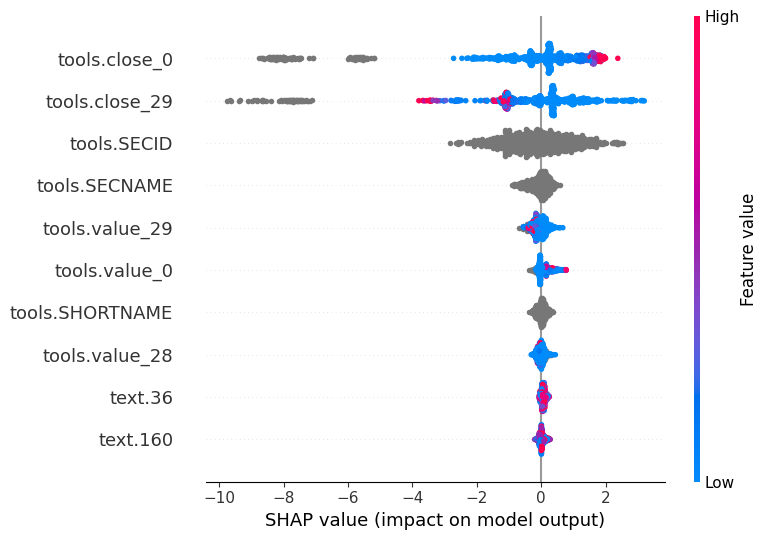

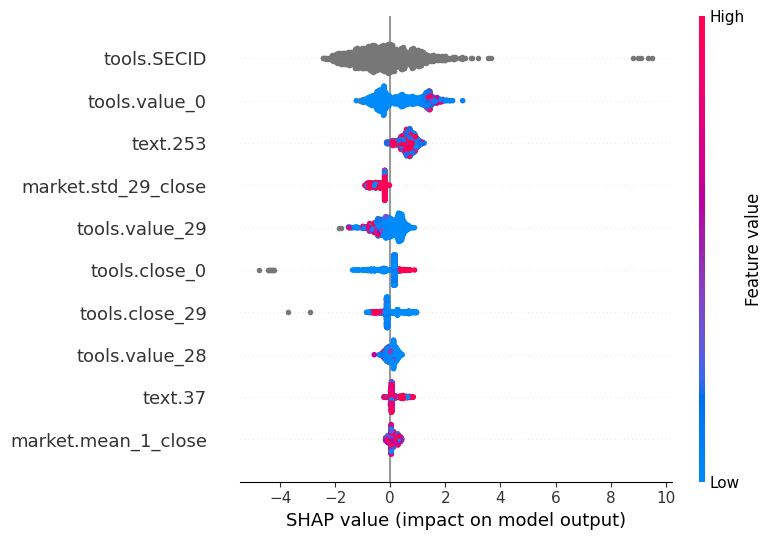

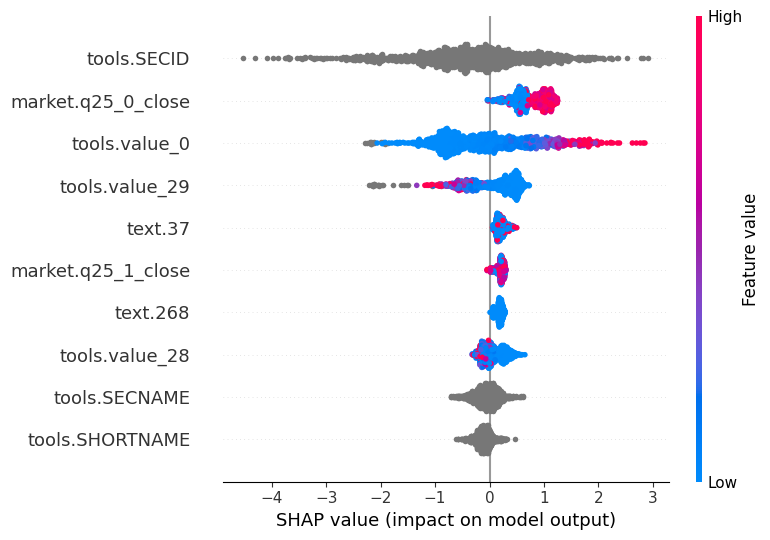

In [26]:
for i in range(3):
    model = models[i]
    X,_ = test_Xy[i]
    shap_test = shap.TreeExplainer(model).shap_values(X)
    shap.summary_plot(shap_test, X, max_display=10)


Итого, самыми значимыми для предсказания фичами являются:
1. SECID
2. Значения свечей за последний и первый дни периода 

Фичи связанные с текстом так же встречаются в топе значимых фич. Иными словами текст извне заметно вляет на педсказание. Хоть и нельзя утверждать это точно из-за плохого качества моделей.

Иными словами гипотеза 2 о влиянии данных извне не опровергается.